In [1]:
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from visturing.properties.prop5 import load_ground_truth
from visturing.ranking import prepare_data, calculate_correlations_with_ground_truth, calculate_correlations, prepare_and_correlate, prepare_and_correlate_order, calculate_spearman

In [3]:
x_gt, y1_gt, y2_gt, y3_gt = load_ground_truth("../../ground_truth_decalogo")
x_gt.shape, y1_gt.shape, y2_gt.shape, y3_gt.shape

((200,), (200,), (200,), (200,))

In [4]:
root_path = "../../Data/Experiment_3"

In [5]:
noises = {p.split("/")[-1].split(".")[0].split("_")[-1]: np.load(p) for p in glob(os.path.join(root_path, "*npy")) if "noises" in p}
for k,v in noises.items(): print(f"{k}: {v.shape}")

3: (10, 40, 256, 256, 3)
12: (10, 40, 256, 256, 3)
a: (10, 40, 256, 256, 3)
6: (10, 40, 256, 256, 3)


In [6]:
bgs = {p.split("/")[-1].split(".")[0].split("_")[-1]: np.load(p) for p in glob(os.path.join(root_path, "*npy")) if "background" in p}
for k,v in bgs.items(): print(f"{k}: {v.shape}")

a: (256, 256, 3)
6: (256, 256, 3)
3: (256, 256, 3)
12: (256, 256, 3)


In [7]:
freqs = np.load(os.path.join(root_path, "freqs.npy"))
freqs

array([ 0.1       ,  0.86666667,  1.63333333,  2.4       ,  3.16666667,
        3.93333333,  4.7       ,  5.46666667,  6.23333333,  7.        ,
        7.76666667,  8.53333333,  9.3       , 10.06666667, 10.83333333,
       11.6       , 12.36666667, 13.13333333, 13.9       , 14.66666667,
       15.43333333, 16.2       , 16.96666667, 17.73333333, 18.5       ,
       19.26666667, 20.03333333, 20.8       , 21.56666667, 22.33333333,
       23.1       , 23.86666667, 24.63333333, 25.4       , 26.16666667,
       26.93333333, 27.7       , 28.46666667, 29.23333333, 30.        ])

In [8]:
import json

import jax
from jax import random, numpy as jnp
import flax
from huggingface_hub import hf_hub_download
from ml_collections import ConfigDict

from paramperceptnet.models import PerceptNet
from paramperceptnet.configs import param_config

In [9]:
# model_name = "ppnet-bio-fitted"
model_name = "ppnet-fully-trained"

In [10]:
config_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                              filename="config.json")
with open(config_path, "r") as f:
    config = ConfigDict(json.load(f))

In [11]:
from safetensors.flax import load_file

weights_path = hf_hub_download(repo_id=f"Jorgvt/{model_name}",
                               filename="weights.safetensors")
variables = load_file(weights_path)
variables = flax.traverse_util.unflatten_dict(variables, sep=".")
state = variables["state"]
params = variables["params"]

In [12]:
model = PerceptNet(config)

In [13]:
params.keys()

dict_keys(['CenterSurroundLogSigmaK_0', 'Color', 'GDNGamma_0', 'GDNGaussian_0', 'GDNSpatioChromaFreqOrient_0', 'GDN_0', 'GaborLayerGammaHumanLike__0', 'LinearScaling_0'])

In [14]:
@jax.jit
def calculate_diffs(img1, img2):
    _, extra_a = model.apply({"params": params, **state}, img1, train=False, capture_intermediates=True)
    _, extra_b = model.apply({"params": params, **state}, img2, train=False, capture_intermediates=True)
    a = extra_a["intermediates"]["GDNSpatioChromaFreqOrient_0"]["__call__"][0]
    b = extra_b["intermediates"]["GDNSpatioChromaFreqOrient_0"]["__call__"][0]
    return ((a-b)**2).mean(axis=(1,2,3))**(1/2)

In [15]:
diffs = {}
for k, noise in noises.items():
    bg = bgs[k][None,...]
    diffs_it = []
    for noise_it in noise:
        diff = calculate_diffs(noise_it, bg)
        # print(noise_it.shape, bg.shape, diff.shape)
        diffs_it.append(diff)
        # break
    diffs_it = np.array(diffs_it)
    diffs[k] = diffs_it.mean(axis=0)
    # break

In [16]:
diffs_a = diffs.pop("a")
diffs_inv = {k:v/diffs_a for k, v in diffs.items()}

/var/folders/fj/7ttqfxt94c5cqdh00xr61t880000gn/T/ipykernel_56382/167548782.py:2: RuntimeWarning: divide by zero encountered in divide
  diffs_inv = {k:v/diffs_a for k, v in diffs.items()}


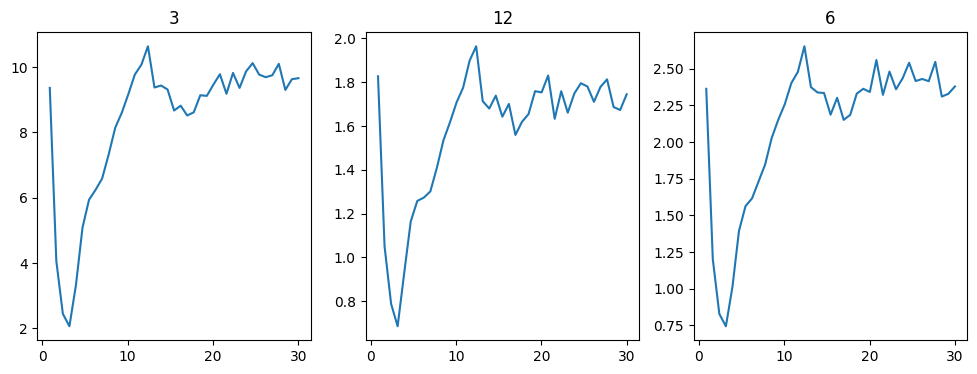

In [17]:
fig, axes = plt.subplots(1,len(diffs_inv), figsize=(12,4))
for ax, (k, diff) in zip(axes.ravel(), diffs_inv.items()):
    ax.plot(freqs, diff)
    ax.set_title(k)
plt.show()

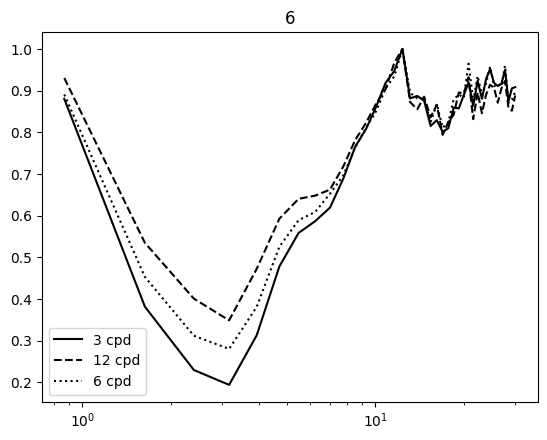

In [18]:
fig, ax = plt.subplots(1,1)
for k, diff in diffs_inv.items():
    if k == "3": style = "solid"
    elif k == "6": style = "dotted"
    elif k == "12": style = "dashed"
    # ax.plot(freqs, diff, linestyle=style, color="k", label=f"{k} cpd")
    ax.plot(freqs[1:], diff[1:]/diff[1:].max(), linestyle=style, color="k", label=f"{k} cpd")
    ax.set_title(k)
plt.xscale("log")
plt.legend()
plt.show()

In [20]:
a, b, c, d1 = prepare_data(freqs[1:], diffs_inv[k][1:], x_gt, y1_gt)
a, b, c, d2 = prepare_data(freqs[1:], diffs_inv[k][1:], x_gt, y2_gt)
a, b, c, d3 = prepare_data(freqs[1:], diffs_inv[k][1:], x_gt, y3_gt)


diffs_stack = np.stack([diffs_inv["3"][1:],
                        diffs_inv["6"][1:],
                        diffs_inv["12"][1:]])
ds = np.stack([d1, d2, d3])
diffs_stack.shape, ds.shape

((3, 39), (3, 39))

In [21]:
calculate_correlations_with_ground_truth(diffs_stack, ds)

{'spearman': np.float64(-0.6410256410256411),
 'kendall': np.float64(-0.6241507779969317),
 'pearson': np.float64(-0.6410256410256407)}

In [22]:
import scipy.stats as stats

In [23]:
stats.pearsonr(diffs_stack.ravel(), ds.ravel())

PearsonRResult(statistic=np.float64(-0.39275331126578256), pvalue=np.float64(1.1867902695234718e-05))